In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
import pickle

In [55]:
df_train = pd.read_csv("C:\\Users\\91878\\Downloads\\fraudTrain.csv")
df_test = pd.read_csv("C:\\Users\\91878\\Downloads\\fraudTest.csv")

In [56]:
df_train['is_train'] = 1  # Mark train rows
df_test['is_train'] = 0   # Mark test rows
df_combined = pd.concat([df_train, df_test], ignore_index=True)

In [57]:
df_combined.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,is_train
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,1


In [58]:
# Explore data types
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [59]:
# Drop irrelevant columns
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'trans_num', 'dob', 'unix_time']
df_combined = df_combined.drop(columns=columns_to_drop)

In [60]:
# Check for missing values
df_combined.isnull().sum()

cc_num        0
merchant      0
category      0
amt           0
gender        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
merch_lat     0
merch_long    0
is_fraud      0
is_train      0
dtype: int64

In [61]:
df_combined['is_fraud'].value_counts()   # 0 : Non-Fraudulent Transactions and 1 : Fraudulent Transactions

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [62]:
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['merchant', 'category', 'gender', 'city', 'state', 'job']

In [63]:
# Frequency encoding for each categorical column
freq_encoding = {}
for col in ['merchant', 'category', 'gender', 'state', 'job', 'city']:
    freq = df_combined[col].value_counts() / len(df_combined)
    freq_encoding[col] = freq.to_dict()
    df_combined[col] = df_combined[col].map(freq)

In [64]:
# Use SelectKBest to select top 5 best features
k = 6  # Select top 6 features
selector = SelectKBest(score_func=mutual_info_classif, k=k)
df_combined_selected = selector.fit_transform(df_combined.drop(['is_fraud'], axis = 1), df_combined["is_fraud"])

mask = selector.get_support()        # Get the boolean mask of selected features
selected_features = df_combined.drop(['is_fraud'], axis = 1).columns[mask]       # Get the selected feature names
print("Selected features:", selected_features)      # Print the selected features

Selected features: Index(['category', 'amt', 'gender', 'city', 'state', 'is_train'], dtype='object')


In [65]:
outliers = []
for feature in df_combined.select_dtypes(include=np.number).drop(columns=['is_train', 'is_fraud']).columns:
    Q1 = df_combined[feature].quantile(0.25)
    Q3 = df_combined[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # Capping and flooring outliers
    df_combined[feature] = np.where(df_combined[feature] < lower_bound, lower_bound, df_combined[feature])
    df_combined[feature] = np.where(df_combined[feature] > upper_bound, upper_bound, df_combined[feature])

In [66]:
df_train = df_combined[df_combined['is_train'] == 1].drop(columns=['is_train', 'merchant', 'city_pop', 'merch_lat', 'merch_long', 'lat', 'long', 'job'])
df_test = df_combined[df_combined['is_train'] == 0].drop(columns=['is_train', 'merchant', 'city_pop', 'merch_lat', 'merch_long', 'lat', 'long', 'job'])

In [67]:
x_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

x_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

print("Class distribution after SMOTE:", y_train_balanced.value_counts())

Class distribution after SMOTE: is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


In [68]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_balanced)
x_test_scaled = scaler.transform(x_test)

## 1. Logistic Regression

In [69]:
model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train_balanced)

y_train_prediction = model.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train_balanced, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train_balanced, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train_balanced, y_train_prediction))

y_test_pred_logistic = model.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_logistic)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_logistic))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_logistic))

Accuracy on training data =  0.8363216925011383
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84   1289169
           1       0.85      0.82      0.83   1289169

    accuracy                           0.84   2578338
   macro avg       0.84      0.84      0.84   2578338
weighted avg       0.84      0.84      0.84   2578338

Confusion Matrix: 
 [[1097376  191793]
 [ 230225 1058944]]


Accuracy on testing data =  0.8510488214367333
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    553574
           1       0.02      0.77      0.04      2145

    accuracy                           0.85    555719
   macro avg       0.51      0.81      0.48    555719
weighted avg       1.00      0.85      0.92    555719

Confusion Matrix: 
 [[471295  82279]
 [   496   1649]]


## 2. Random Forest

In [70]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_balanced, y_train_balanced)

y_train_prediction = rf.predict(x_train_balanced)
training_data_accuracy = accuracy_score(y_train_balanced, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train_balanced, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train_balanced, y_train_prediction))

y_test_pred_rf = rf.predict(x_test)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_rf)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_rf))

Accuracy on training data =  0.9966001354360833
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1289169
           1       0.99      1.00      1.00   1289169

    accuracy                           1.00   2578338
   macro avg       1.00      1.00      1.00   2578338
weighted avg       1.00      1.00      1.00   2578338

Confusion Matrix: 
 [[1281675    7494]
 [   1272 1287897]]


Accuracy on testing data =  0.9897934027809019
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.13      0.30      0.19      2145

    accuracy                           0.99    555719
   macro avg       0.57      0.65      0.59    555719
weighted avg       0.99      0.99      0.99    555719

Confusion Matrix: 
 [[549401   4173]
 [  1499    646]]


## 3. Decision Tree

In [71]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train_balanced, y_train_balanced)

y_train_prediction = decision_tree.predict(x_train_balanced)
training_data_accuracy = accuracy_score(y_train_balanced, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train_balanced, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train_balanced, y_train_prediction))

y_test_pred_dt = decision_tree.predict(x_test)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_dt)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_dt))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_dt))

Accuracy on training data =  0.9966016868230619
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1289169
           1       0.99      1.00      1.00   1289169

    accuracy                           1.00   2578338
   macro avg       1.00      1.00      1.00   2578338
weighted avg       1.00      1.00      1.00   2578338

Confusion Matrix: 
 [[1281715    7454]
 [   1308 1287861]]


Accuracy on testing data =  0.9903422413126058
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.15      0.31      0.20      2145

    accuracy                           0.99    555719
   macro avg       0.57      0.65      0.60    555719
weighted avg       0.99      0.99      0.99    555719

Confusion Matrix: 
 [[549688   3886]
 [  1481    664]]


## 4. K-Nearest Neighbors

In [72]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train_balanced)

y_train_prediction = knn.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train_balanced, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train_balanced, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train_balanced, y_train_prediction))

y_test_pred_knn = knn.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_knn)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_knn))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_knn))

Accuracy on training data =  0.9512752013118528
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95   1289169
           1       0.99      0.92      0.95   1289169

    accuracy                           0.95   2578338
   macro avg       0.95      0.95      0.95   2578338
weighted avg       0.95      0.95      0.95   2578338

Confusion Matrix: 
 [[1271656   17513]
 [ 108116 1181053]]


Accuracy on testing data =  0.9758349093696634
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.03      0.19      0.06      2145

    accuracy                           0.98    555719
   macro avg       0.51      0.58      0.52    555719
weighted avg       0.99      0.98      0.98    555719

Confusion Matrix: 
 [[541893  11681]
 [  1748    397]]


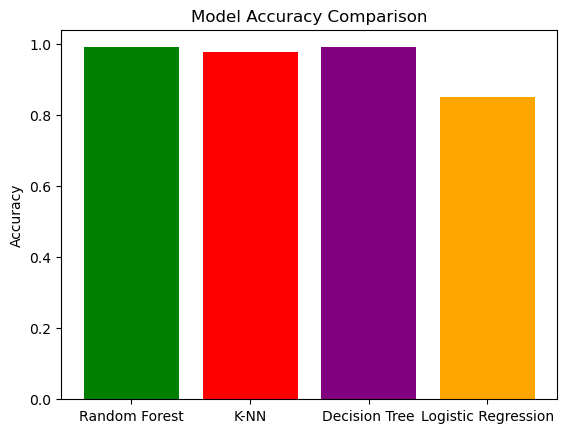

In [73]:
# Final comparison of the model accuracies
models = ['Random Forest', 'K-NN', 'Decision Tree', 'Logistic Regression']
accuracies = [
    accuracy_score(y_test, y_test_pred_rf),
    accuracy_score(y_test, y_test_pred_knn),
    accuracy_score(y_test, y_test_pred_dt),
    accuracy_score(y_test, y_test_pred_logistic)
]

plt.bar(models, accuracies, color=['green', 'red', 'purple', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

In [74]:
# Predict probabilities for test set
y_test_prob = model.predict_proba(x_test)[:, 1]

# Probabilistic Threshold Tuning with Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)  # Index with the highest F1 score
optimal_threshold = thresholds[optimal_idx]

# Predict with the optimal threshold
y_test_pred_optimal = (y_test_prob >= optimal_threshold).astype(int)

# Display metrics using the optimized threshold
print("\nOptimal Threshold:", optimal_threshold)
print("\nTesting Accuracy with Optimal Threshold:", accuracy_score(y_test, y_test_pred_optimal))
print("Testing Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_test_pred_optimal))
print("Testing Classification Report with Optimal Threshold:\n", classification_report(y_test, y_test_pred_optimal))

C:\Users\91878\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



Optimal Threshold: 0.0

Testing Accuracy with Optimal Threshold: 0.0038598644278853163
Testing Confusion Matrix with Optimal Threshold:
 [[     0 553574]
 [     0   2145]]


C:\Users\91878\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91878\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    553574
           1       0.00      1.00      0.01      2145

    accuracy                           0.00    555719
   macro avg       0.00      0.50      0.00    555719
weighted avg       0.00      0.00      0.00    555719



C:\Users\91878\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': x_train.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print("\nFeature Importances:\n", feature_importance_df)


Feature Importances:
     feature  importance
2       amt    0.533020
1  category    0.302002
4      city    0.080491
6       zip    0.029909
0    cc_num    0.028732
5     state    0.018730
3    gender    0.007117


In [76]:
with open('credit_card_fraud_detection.pickle', 'wb') as file:
     pickle.dump(decision_tree, file)

In [77]:
# Save the frequency encoding mappings
with open('frequency_encoding.pickle', 'wb') as f:
    pickle.dump(freq_encoding, f)

In [78]:
# Save the scaler
with open('scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)